# Домашнее задание

Всего у вас 2 домашних задания:

### 1) Бинарная классификация на примере детекции фрода на кредитных картах (6 баллов)
(в этом файле)

### 2) Небинарная классификация на вашем датасете (6 баллов)
(тоже в этом файле)

# 1 - Бинарная классификация на примере детекции фрода на кредитных картах (суммарно 6 баллов)
У вас есть информация о множесте транзакций. Вам нужно научиться предсказывать, какие из них мошеннические, а какие нет.

### (1 балл) Считайте данные
Сами считайте и предобработайте, если надо, данные из файла creditcard.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Тинькофф.Поколение/creditcard.csv")

Посмотрим на данные.

In [4]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Проверим наличие пропусков в данных.

In [5]:
data.isna().any().sum()

0

Посмотрим на типы данных признаков.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Построим графики распределения признаков по классам. (первые 10 признаков)

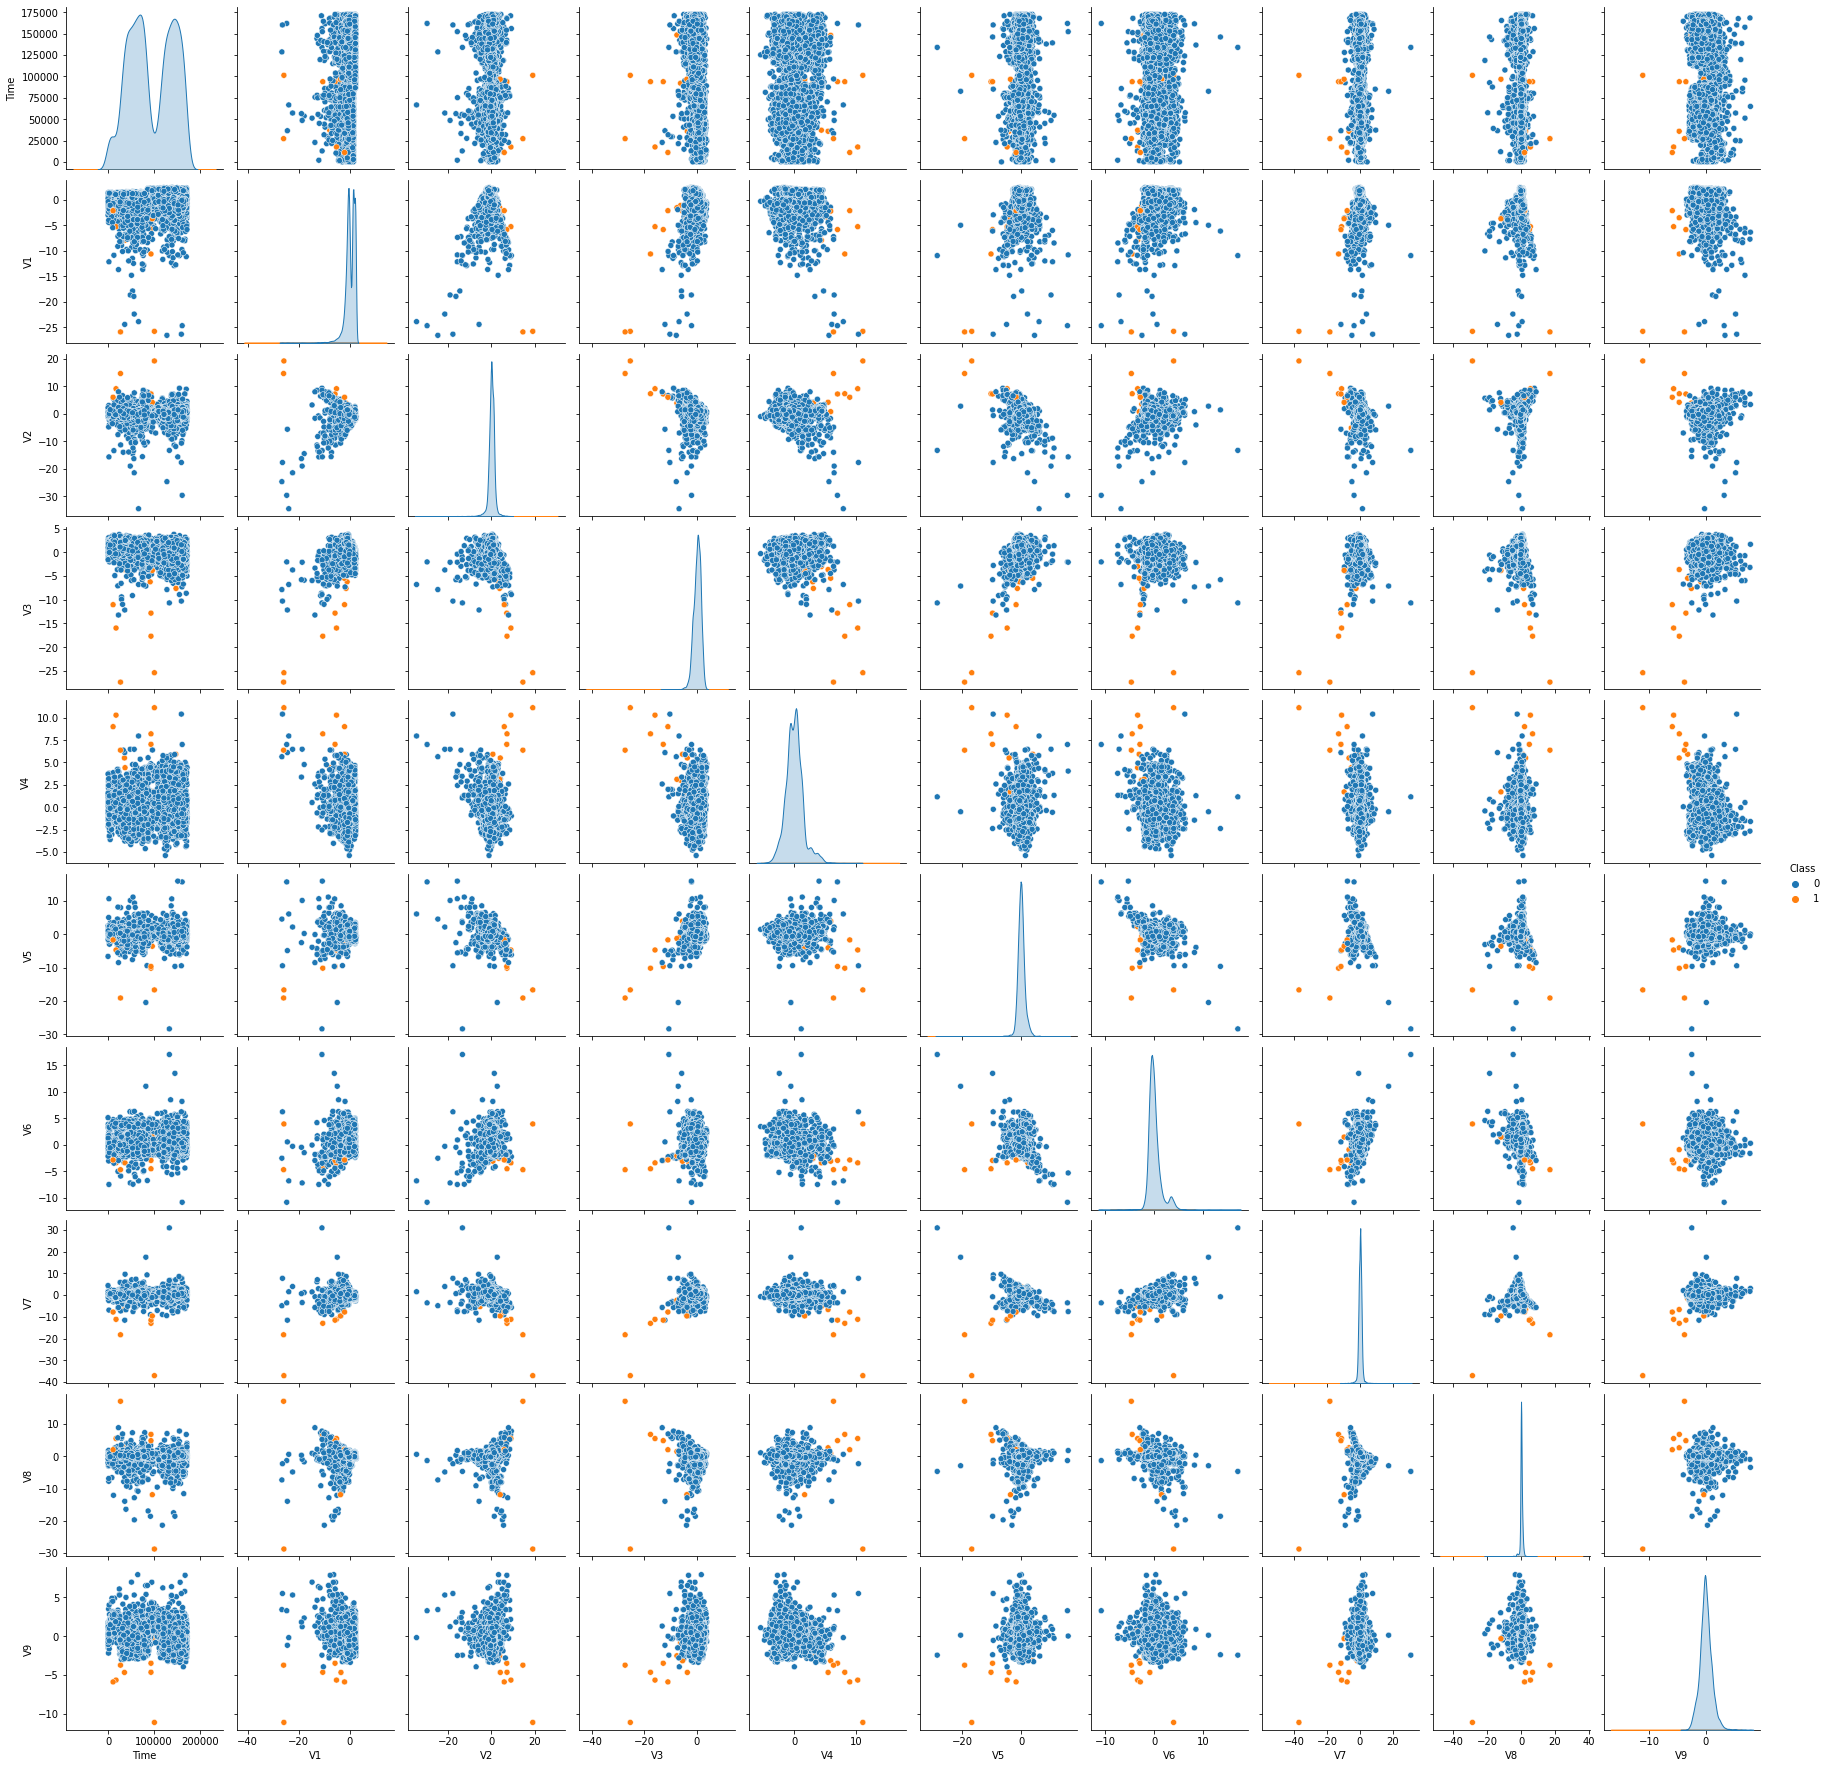

In [ ]:
sns.pairplot(data[list(data.iloc[:, :10].columns)+['Class']].sample(10000), hue='Class')

Посмотрим на распределение таргета. Датасет крайне несбалансированный.

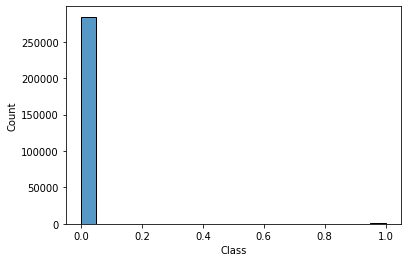

In [ ]:
sns.histplot(data['Class'])

Посмотрим на распределения именованных признаков.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


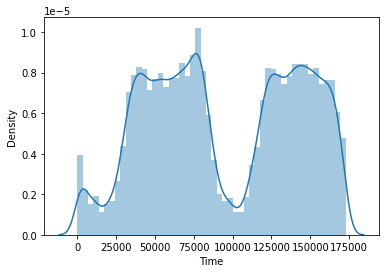

In [ ]:
sns.distplot(data['Time'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


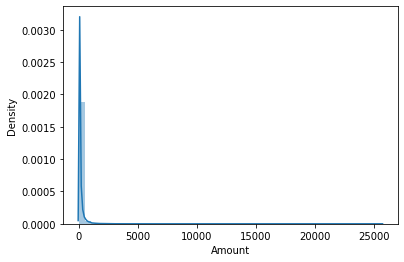

In [ ]:
sns.distplot(data['Amount'])

Так как распределения очень неравномерные, то используем RobustScaler (он менее восприимчив к выбросам) для стандартизации признаков. Остальные данные не трогаем, они в процессе кодировки уже были стандартизированы.

In [7]:
rs = RobustScaler()
data['Amount'] = rs.fit_transform(data['Amount'].values.reshape(-1,1))
data['Time'] = rs.fit_transform(data['Time'].values.reshape(-1,1))

In [8]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1.034951,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.296653,0
284803,1.034963,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,0
284804,1.034975,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,0
284805,1.034975,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.167680,0


Разделим датасет на данные и на таргет-переменную.

In [76]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [10]:
X.shape, y.shape

((284807, 30), (284807,))

### (2 балла) Обучите несколько моделей, посмотрите на метрики.
Как модели точно возьмите LogisticRegression, KNN и константу, можете придумать еще какие-нибудь.

Как метрики точно возьмите accuracy, precision, recall, f1, roc_auc. Постройте ROC-кривую.

Наивный Алгоритм.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def draw_curve(y_test, preds):
  ns_probs = [0 for _ in range(len(y_test))]
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, preds)
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(lr_fpr, lr_tpr, marker='.')
  plt.show()

In [ ]:
class NaiveAlgorithm():
  def fit(self, X, y):
    pass

  def predict(self, y):
    return np.zeros(y.shape[0])

In [ ]:
naiv_alg = NaiveAlgorithm()
naiv_alg.fit(X_train, y_train)
preds_na = naiv_alg.predict(X_test)

In [ ]:
print(classification_report(y_test, preds_na, digits=5))
print('Accuracy =', accuracy_score(y_test, preds_na))
print('ROC AUC =', roc_auc_score(y_test, preds_na))

              precision    recall  f1-score   support

           0    0.99807   1.00000   0.99903     56852
           1    0.00000   0.00000   0.00000       110

    accuracy                        0.99807     56962
   macro avg    0.49903   0.50000   0.49952     56962
weighted avg    0.99614   0.99807   0.99710     56962

Accuracy = 0.9980688880306169
ROC AUC = 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


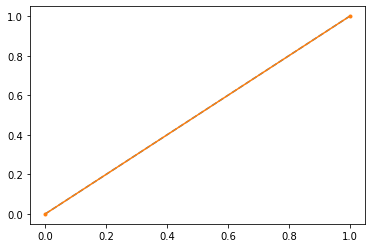

In [ ]:
draw_curve(y_test, preds_na)

Логистическая Регрессия.

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
score_lg = cross_validate(log_reg, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
list(map(lambda x: print(x[0], np.mean(x[1])), score_lg.items()))
print()

fit_time 19.193816566467284
score_time 0.16884913444519042
test_accuracy 0.9972823875735802
test_precision 0.7532590845733698
test_recall 0.582519068233354
test_f1 0.556889927028043
test_roc_auc 0.9437909785831231



In [ ]:
log_reg.fit(X_train, y_train)
preds_lg = log_reg.predict_proba(X_test)
preds_lg = preds_lg[:, 1]

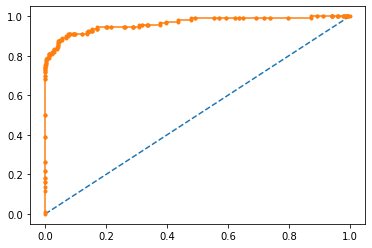

In [ ]:
draw_curve(y_test, preds_lg)

Классификатор kNN.

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
score_knn = cross_validate(knn, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
list(map(lambda x: print(x[0], np.mean(x[1])), score_knn.items()))
print()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time 223.9779592037201
score_time 4.214975881576538
test_accuracy 0.451985362546602
test_precision 0.000796364252339495
test_recall 0.34034219748505457
test_f1 0.0015886270827852888
test_roc_auc 0.39429518530930197



In [ ]:
knn.fit(X_train, y_train)
preds_knn = knn.predict_proba(X_test)
preds_knn = preds_knn[:, 1]

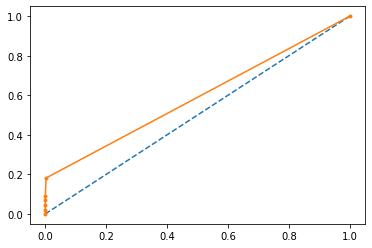

In [ ]:
draw_curve(y_test, preds_knn)

### (1 балл) Выберите одну метрику, которую вы будете максимизировать

Представьте, что вы решаете задачу автоматического поиска мошеннических транзакций, чтобы ваш робот автоматически банил пользователей, который их осуществляют.

Обоснуйте свой выбор.

### (2 балла) Переберите гиперпараметры разных моделей, попытайтесь добиться лучшего результата по этой метрике

Постройте график для каждого перебора, сделайте красивый отчет (не надо просто говорить "я решил выбрать 2, 0.7 и 6, так не пойдет".

Можно преобразовывать датасет, преобразовывать, добавлять, удалять фичи, всё что угодно.

Отсутствие результата тоже результат (вдруг вы перебрали кучу вещей, а лучший все еще самый первый запуск, главное что перебрали).

### Метрика - F1:

Precision позволяет нам оценить, сколько мошеннических транзакций было предсказано корректно из всех предсказанных. Recall позволяет нам оценить, сколько мошеннических транзакций было предсказано корректно из всех существующих.

Чтобы достичь баланса между двумя данными метриками, мы будем использовать F1 метрику, которая зависит и от precision, и от recall.

Создадим пайплайн:

Будем отбирать k подходящих признаков с помощью алгоритма ANOVA. В качестве модели возьмем Логистическую Регрессию. Стандартизировать данные не будем, это уже было сделано ранее.

In [18]:
pipe = Pipeline([('anova', SelectKBest(f_classif)), 
                 ('log_reg', LogisticRegression(max_iter=1000))])

In [33]:
params = {
    'log_reg__C': np.arange(0.1, 1.1, 0.1),
    'anova__k': np.arange(5, 16, 1)
}
best_model = GridSearchCV(pipe, params, scoring='f1')
best_model.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('anova',
                                        SelectKBest(k=10,
                                                    score_func=<function f_classif at 0x7f019b6a5b00>)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
                                                           multi_class='auto',
                                                    

Лучшие параметры и лучший скор, полученные с помощью GridSearch.

In [34]:
best_model.best_params_, best_model.best_score_

({'anova__k': 13, 'log_reg__C': 0.1}, 0.7048589963711652)

Преобразуем результаты GridSearch в датафрейм для удобного пользования.

In [35]:
gs_data = pd.DataFrame(best_model.cv_results_)
gs_data.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_anova__k,param_log_reg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.782691,0.068905,0.042971,0.000370,5,0.1,"{'anova__k': 5, 'log_reg__C': 0.1}",0.752294,0.742138,0.577465,0.775000,0.630137,0.695407,0.077363,100
1,0.749352,0.030233,0.042646,0.001083,5,0.2,"{'anova__k': 5, 'log_reg__C': 0.2}",0.752294,0.742138,0.587413,0.767296,0.630137,0.695855,0.072815,93
2,0.753969,0.029799,0.042828,0.000592,5,0.3,"{'anova__k': 5, 'log_reg__C': 0.30000000000000...",0.752294,0.742138,0.587413,0.767296,0.630137,0.695855,0.072815,93
3,0.755085,0.030609,0.042151,0.000462,5,0.4,"{'anova__k': 5, 'log_reg__C': 0.4}",0.752294,0.742138,0.587413,0.767296,0.630137,0.695855,0.072815,93
4,0.768967,0.037602,0.046099,0.004318,5,0.5,"{'anova__k': 5, 'log_reg__C': 0.5}",0.752294,0.742138,0.587413,0.767296,0.630137,0.695855,0.072815,93


Построим график зависимости скора от `param_log_reg__C` при `param_anova__k	= 13` (лучший результат).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


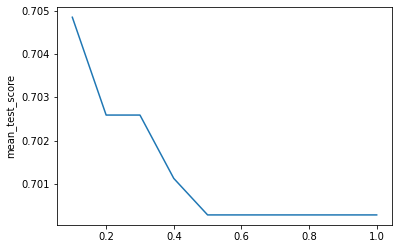

In [36]:
sns.lineplot(np.arange(0.1, 1.1, 0.1), gs_data[gs_data['param_anova__k'] == 13]['mean_test_score'])

Построим график зависимости скора от `param_anova__k` при `param_log_reg__C = 0.01` (лучший результат).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


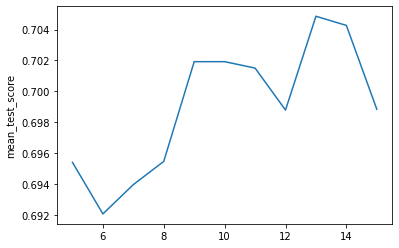

In [37]:
sns.lineplot(np.arange(5, 16, 1), gs_data[gs_data['param_log_reg__C']	== 0.1]['mean_test_score'])

In [77]:
pipe = Pipeline([('anova', SelectKBest(f_classif, k=13)), 
                 ('log_reg', LogisticRegression(max_iter=1000, C=0.1))])

In [78]:
preds = cross_val_score(pipe, X, y, scoring='f1')

Точность модели по метрике f1 при `cv = 5`.

In [79]:
np.mean(preds)

0.7048589963711652

# 2 - Небинарная классификация на вашем датасете (суммарно 6 баллов)

### (2 балла) Выберите какой-нибудь интересный вам датасет, скачайте его и считайте данные

Творческое задание - найти в интернете (или собрать свой даже) датасет, сохранить его в файл, и загрузить сюда.

Требования:

- он должен быть немаленький (хотя бы 500 объектов, лучше больше)
- он должен быть интересный
- таргет должен быть небинарным классом

Минус балл, если ваш датасет с кем-нибудь повторится.

In [41]:
my_data = pd.read_csv("/content/drive/MyDrive/Тинькофф.Поколение/Data_Cortex_Nuclear.csv")

Посмотрим на данные.

In [43]:
my_data.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.48

In [45]:
my_data.shape

(1080, 82)

Проверим типы данных признаков.

In [46]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MouseID          1080 non-null   object 
 1   DYRK1A_N         1077 non-null   float64
 2   ITSN1_N          1077 non-null   float64
 3   BDNF_N           1077 non-null   float64
 4   NR1_N            1077 non-null   float64
 5   NR2A_N           1077 non-null   float64
 6   pAKT_N           1077 non-null   float64
 7   pBRAF_N          1077 non-null   float64
 8   pCAMKII_N        1077 non-null   float64
 9   pCREB_N          1077 non-null   float64
 10  pELK_N           1077 non-null   float64
 11  pERK_N           1077 non-null   float64
 12  pJNK_N           1077 non-null   float64
 13  PKCA_N           1077 non-null   float64
 14  pMEK_N           1077 non-null   float64
 15  pNR1_N           1077 non-null   float64
 16  pNR2A_N          1077 non-null   float64
 17  pNR2B_N       

В данных есть пропущенные значения. Заполним их средними по признаку.

In [47]:
my_data.isna().any().sum()

49

In [49]:
my_data.isna().any()

MouseID      False
DYRK1A_N      True
ITSN1_N       True
BDNF_N        True
NR1_N         True
             ...  
CaNA_N       False
Genotype     False
Treatment    False
Behavior     False
class        False
Length: 82, dtype: bool

In [50]:
my_data.fillna(my_data.mean(), inplace=True)
my_data.isna().any().sum()

0

Посмотрим на распределение признаков.

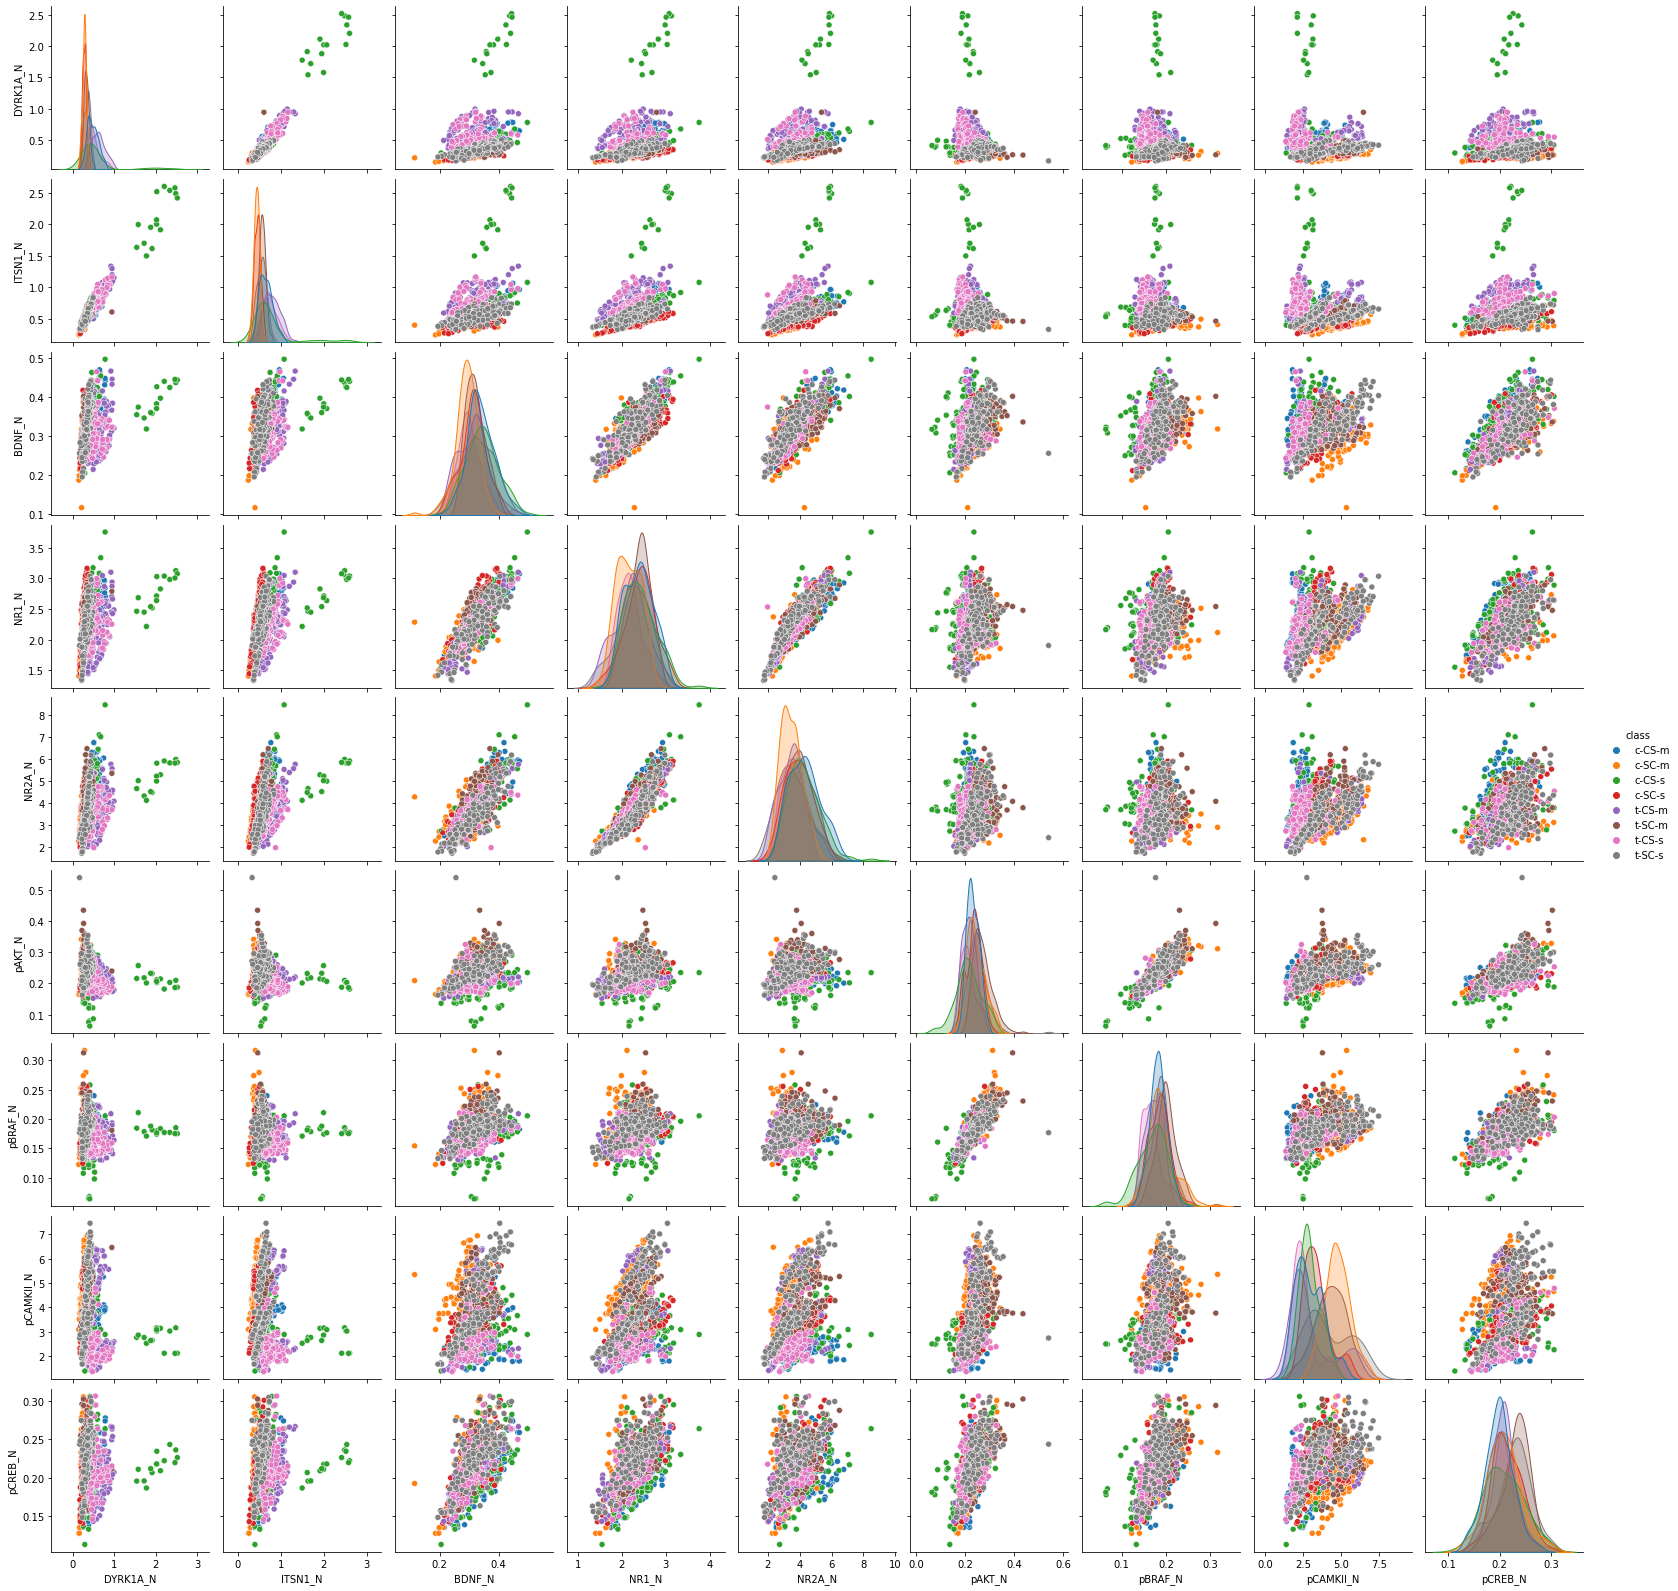

In [ ]:
sns.pairplot(my_data[list(my_data.iloc[:, :10].columns)+['class']], hue='class')

Посмотрим на распределение классов. Датасет сбалансированный.

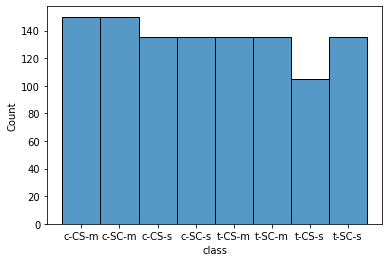

In [ ]:
sns.histplot(my_data['class'])

In [85]:
X = my_data.iloc[:, 1:-1]
y = my_data.iloc[:, -1]

Закодируем категориальные признаки.

In [93]:
X = pd.get_dummies(X)

(1080, 83)

### (2 балла) Обучите несколько моделей, посмотрите на метрики.
Как модели точно возьмите LogisticRegression, KNN и константу, можете придумать еще какие-нибудь.

Как метрики точно возьмите accuracy, разные усреднения precision, recall и f1.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Наивный Алгоритм.

In [54]:
class NaiveAlgorithm():
  def fit(self, X, y):
    pass

  def predict(self, y):
    return np.full(y.shape, 'c-CS-m')

In [55]:
naiv_alg = NaiveAlgorithm()
naiv_alg.fit(X_train, y_train)
preds_na = naiv_alg.predict(y_test)

In [61]:
print('Accuracy =', accuracy_score(y_test, preds_na))
print('Precision_micro =', precision_score(y_test, preds_na, average='macro'))
print('Recall_micro =', recall_score(y_test, preds_na, average='macro'))
print('F1_micro =', f1_score(y_test, preds_na, average='macro'))

Accuracy = 0.16666666666666666
Precision_micro = 0.020833333333333332
Recall_micro = 0.125
F1_micro = 0.03571428571428571


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Логистическая Регрессия.

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
score_lg = cross_validate(log_reg, X, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

In [ ]:
list(map(lambda x: print(x[0], np.mean(x[1])), score_lg.items()))
print()

fit_time 0.5620396614074707
score_time 0.010508346557617187
test_accuracy 0.9879629629629629
test_precision_weighted 0.991875
test_recall_weighted 0.9879629629629629
test_f1_weighted 0.9872224244630505



Классификатор kNN.

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
score_knn = cross_validate(knn, X, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
list(map(lambda x: print(x[0], np.mean(x[1])), score_knn.items()))
print()

fit_time 0.00751028060913086
score_time 0.030287837982177733
test_accuracy 0.9425925925925925
test_precision_weighted 0.9562307079089212
test_recall_weighted 0.9425925925925925
test_f1_weighted 0.9385144058379857



### (2 балла) Выберите метрику, которую вы хотите максимизировать. Переберите гиперпараметры, постарайтесь найти модель, которая максимизирует эту метрику.

Обоснуйте свой выбор. Напишите красивый отчет с графиками. Добились ли вы результатов, которых хотели добиться для этого датасета?

### Метрика - accuracy:
Так как мы имеем сбалансированный датасет с задачей небинарной классификации, то можно использовать метрику accuracy.

Создадим пайплайн:

Будем стандартизировать данные, а также отбирать k подходящих признаков с помощью алгоритма ANOVA. В качестве модели возьмем Логистическую Регрессию.

In [62]:
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('anova', SelectKBest(f_classif)), 
                 ('log_reg', LogisticRegression(max_iter=1000))])

In [ ]:
params = {
    'log_reg__C': np.arange(0.01, 2, 0.05),
    'anova__k': np.arange(1, 51, 1)
}
best_model = GridSearchCV(pipe, params, scoring='accuracy')
best_model.fit(X, y)

Лучшие параметры и лучший скор, полученные с помощью GridSearch.

In [68]:
best_model.best_params_, best_model.best_score_

({'anova__k': 5, 'log_reg__C': 0.01}, 1.0)

Преобразуем результаты GridSearch в датафрейм для удобного пользования.

In [69]:
gs_data = pd.DataFrame(best_model.cv_results_)
gs_data.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_anova__k,param_log_reg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019269,0.000600,0.002107,0.000126,1,0.01,"{'anova__k': 1, 'log_reg__C': 0.01}",0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.0,1921
1,0.021234,0.001309,0.001964,0.000067,1,0.06,"{'anova__k': 1, 'log_reg__C': 0.06000000000000...",0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.0,1921
2,0.025129,0.003497,0.002311,0.000512,1,0.11,"{'anova__k': 1, 'log_reg__C': 0.11}",0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.0,1921
3,0.025063,0.001713,0.002358,0.000415,1,0.16,"{'anova__k': 1, 'log_reg__C': 0.16000000000000...",0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.0,1921
4,0.026820,0.004175,0.002011,0.000064,1,0.21,"{'anova__k': 1, 'log_reg__C': 0.21000000000000...",0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.0,1921


Построим график зависимости скора от `param_log_reg__C` при `param_anova__k	= 5` (лучший результат).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


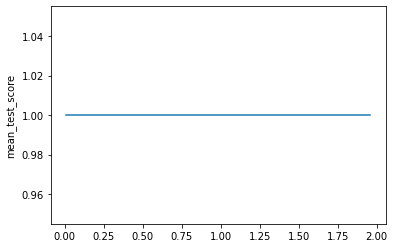

In [70]:
sns.lineplot(np.arange(0.01, 2, 0.05), gs_data[gs_data['param_anova__k']	== 5]['mean_test_score'])

Построим график зависимости скора от `param_anova__k` при `param_log_reg__C = 0.01` (лучший результат).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


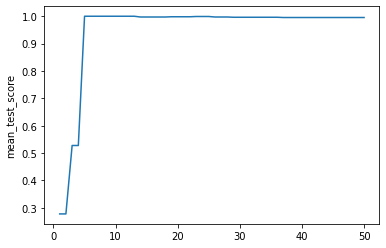

In [71]:
sns.lineplot(np.arange(1, 51, 1), gs_data[gs_data['param_log_reg__C']	== 0.01]['mean_test_score'])

In [88]:
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('anova', SelectKBest(f_classif, k=5)), 
                 ('log_reg', LogisticRegression(max_iter=1000, C=0.01))])

In [92]:
preds = cross_val_score(pipe, X, y, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Точность модели по метрике accuracy при `cv = 5`.

In [91]:
np.mean(preds)

1.0